# COMPUTER PROJECT

Install necessary packages.

In [ ]:
import numpy as np
import scipy.stats as stat
import pandas as pd
import matplotlib.pyplot as plt

First, the data from the csv is read into a Pandas dataframe.

In [ ]:
stocks = pd.read_csv('project_data.csv')
stocks

,Date,BHP,CSL,NAB,TCL,TLS
0,1/07/2022,35.47,264.19,26.01,13.90,3.67
1,4/07/2022,35.34,269.66,26.23,13.81,3.72
2,5/07/2022,35.42,273.72,26.14,13.66,3.72
3,6/07/2022,33.44,280.77,26.61,13.65,3.77
4,7/07/2022,34.49,281.63,26.61,13.58,3.72
...,...,...,...,...,...,...
247,26/06/2023,43.24,277.92,25.57,14.00,4.22
248,27/06/2023,43.89,276.98,25.75,14.04,4.20
249,28/06/2023,44.19,276.29,26.25,14.18,4.25
250,29/06/2023,43.73,276.24,26.35,14.19,4.23


There are 6 columns. The first column corresponds to the date, and the other columns correspond to the stock prices of the company denoted at the head of the column.

# Question 1

The returns are calculated for each column from the stock values. Then the means and covariances for these returns are computed, and saved in *return_means* and *return_covs* respectively.

In [ ]:
returns = []
for col in stocks.columns:
  if col != 'Date':
    returns.append(stocks[col]/stocks[col].shift(1) - 1)
    returns[-1] = returns[-1][1:]

return_means = []
for i in returns:
  mean = np.mean(i)
  return_means.append(round(mean, 5))

return_covs = np.cov(returns)
for i in return_covs:
  for j, k in enumerate(i):
    i[j] = round(k, 5)

print("Mean returns: ", return_means)
print("Returns covariance matrix: \n", return_covs)

Mean returns:  [0.00099, 0.00023, 0.00013, 0.00015, 0.00058]
Returns covariance matrix: 
 [[ 3.0e-04 -1.0e-05  3.0e-05  2.0e-05 -1.0e-05]
 [-1.0e-05  1.2e-04  3.0e-05  4.0e-05  3.0e-05]
 [ 3.0e-05  3.0e-05  1.5e-04  4.0e-05  2.0e-05]
 [ 2.0e-05  4.0e-05  4.0e-05  1.0e-04  3.0e-05]
 [-1.0e-05  3.0e-05  2.0e-05  3.0e-05  7.0e-05]]


The values for the mean returns and covariance matrix are as expected.



# Question 2


To find an optimal portolio is to solve this quadratic programming problem.

$min_{x \in R} Z(x) = -t\vec x^T\vec r
+ \frac{1}{2}\vec x^T C \vec x$

$s.t. \vec x^T \vec e = 1$

The solution is $\vec x = \vec \alpha + t\vec \beta$. Therefore, these functions must be defined to compute the optimal porfolio. $t$ is the risk aversion parameter.

In [ ]:
# define alpha and beta functions

def alpha(C):
  C_inv = np.linalg.inv(C)
  e = np.ones(len(C_inv))
  a = np.dot(np.dot(e, C_inv), e)

  return 1/a * np.dot(C_inv, np.ones(len(C_inv)))

def beta(r, C):
  C_inv = np.linalg.inv(C)
  e = np.ones(len(C_inv))
  a = np.dot(np.dot(e, C_inv), e)
  b = np.dot(np.dot(r, C_inv), e)

  return np.dot(C_inv, r) - b/a * np.dot(C_inv, e)

print(beta(return_covs))

[0.13629422 0.16810893 0.11745991 0.13642148 0.44171545]


The mean and variance of the optimal portfolio are computed as below.

In [ ]:
def mu(t, r, C):
  C_inv = np.linalg.inv(C)
  e = np.ones(len(C_inv))
  a = np.dot(np.dot(e, C_inv), e)
  b = np.dot(np.dot(r, C_inv), e)
  c = np.dot(np.dot(r, C_inv), r)
  d = a * c - b ** 2

  return (b + d * t) / a


def sigma(t, r, C):
  C_inv = np.linalg.inv(C)
  e = np.ones(len(C_inv))
  a = np.dot(np.dot(e, C_inv), e)
  b = np.dot(np.dot(r, C_inv), e)
  c = np.dot(np.dot(r, C_inv), r)
  d = a * c - b ** 2

  return np.sqrt((1 + d * t ** 2) / a)

The following functions return the expected return and risk, respectively, for a given portfolio in this market.

In [ ]:
def find_return(portfolio):
  sum = 0
  for i, val in enumerate(return_means):
    sum += val * portfolio[i]
  return sum

def find_risk(portfolio):
  sum = 0
  for i, val1 in enumerate(return_covs):
    for j, val2 in enumerate(val1):
      sum += portfolio[i] * val2 * portfolio[j]
  return np.sqrt(sum)

The function *x_general* return the optimal portfolio for a given combination of $t$ parameter, expected returns and covariance matrix.

In [ ]:
  # optimal portfolio vector is determined by alpha, beta and the risk aversion
  def x_general(t, r, C):
    return alpha(C) + t * beta(r, C)

In [ ]:
# define the optimal portfolio for the stocks data
def x(t):
  return x_general(t, return_means, return_covs)

The following graph depicts the $t$ values for which the optimal portfolios have no short-selling.

Text(0, 0.5, 'Short-selling (No = 1, Yes = 0)')

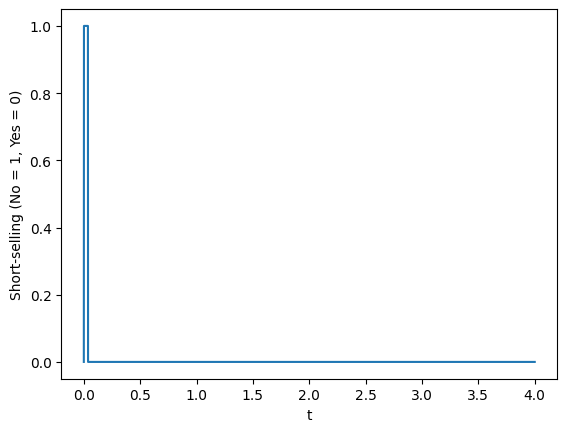

In [ ]:
# define a set of possible t values
t_vec = np.linspace(0.0, 4.0, num=10000)

# find the optimal portfolio for each value of t
x_matrix = []
for t in t_vec:
  x_matrix.append(x(t))

# find which portfolios have no short-selling
no_short_selling = []
nss_t_vals = []

# 1 is no short selling, 0 is short selling
y = np.zeros(len(t_vec))

for j, portfolio in enumerate(x_matrix):
  if j == 0:
    continue
  short_selling = False
  for i in portfolio:
    if i < 0:
      short_selling = True
  if not short_selling:
    no_short_selling.append(portfolio)
    nss_t_vals.append(t_vec[j]) # save the t-value
    y[j] = 1

plt.plot(t_vec, y)
plt.xlabel('t')
plt.ylabel('Short-selling (No = 1, Yes = 0)')

There is a range of t values for which there is no short-selling. Above a certain values, the optimal portfolio involves short-selling, and bellow it, there is no short-selling. It is necessary to find what this value is.


In [ ]:
upper_limit = 0
for i, val in enumerate(y):
  if i < len(y) - 1:
    if (y[i + 1] == 0 and val == 1):
      upper_limit = t_vec[i]

print("If t <=", round(upper_limit, 5), "then the optimal portfolio involves no short-selling.\n",
  "If t >", round(upper_limit, 5), "then the optimal portfolio involves short-selling.")

If t <= 0.0364 then the optimal portfolio involves no short-selling.
 If t > 0.0364 then the optimal portfolio involves short-selling.


# Question 3

## a)

The optimal portfolio for $t=0.04$ may be found from the function. If the portfolio is $10,000, then each element of the portfolio vector may be multiplied by this amount, likewise the mean and variance of the return. The risk may be multiplied by the square root.

In [ ]:
t = 0.04
portfolio = x(t)

print("Portfolio for t = 0.04: ")

for i, val in enumerate(portfolio):
  if val >= 0:
    print('  ' + stocks.columns[i + 1] + ':', '$' + str(int(round(val*10000, 0))))
  else:
    print('  ' + stocks.columns[i + 1] + ':', '-$' + str(abs(int(round(val*10000, 0)))))
print('\n')

print("Mean rerturn:",
      '$' + str((round(find_return(portfolio) * 10000, 2))))

print("Risk:",
      '$' + str((round(find_risk(portfolio) * 100, 3))))

Portfolio for t = 0.04: 
  BHP: $2292
  CSL: $1212
  NAB: $335
  TCL: -$119
  TLS: $6281


Mean rerturn: $6.22
Risk: $0.688


## b)



With the restriction of no short-selling, the optimal portfolio may be found from the unconstrained optimal portfolio. The element of the portfolio that is negative is set to zero. Then an optimal portfolio is found in a market that excludes that asset.

In [ ]:
means_restricted = return_means.copy()
means_restricted.pop(3)

covs_restricted = return_covs.tolist()
covs_restricted.pop(3)
for i in covs_restricted:
  i.pop(3)
covs_restricted

[[0.0003, -1e-05, 3e-05, -1e-05],
 [-1e-05, 0.00012, 3e-05, 3e-05],
 [3e-05, 3e-05, 0.00015, 2e-05],
 [-1e-05, 3e-05, 2e-05, 7e-05]]

In [ ]:
restricted_portfolio = (x_general(0.04, means_restricted, covs_restricted)).tolist()
restricted_portfolio.insert(3, 0)
restricted_portfolio

[0.2279163179916318,
 0.11792468619246858,
 0.031062761506276126,
 0,
 0.6230962343096234]

As before, the portfolio quantities are multiplied by the $10000 invested, and then displayed below.

In [ ]:
print("Portfolio for t = 0.04 with no short-selling: ")

for i, val in enumerate(restricted_portfolio):
  if val >= 0:
    print('  ' + stocks.columns[i + 1] + ':', '$' + str(int(round(val*10000, 0))))
  else:
    print('  ' + stocks.columns[i + 1] + ':', '-$' + str(abs(int(round(val*10000, 0)))))
print('\n')

print("Mean rerturn:",
      '$' + str((round(find_return(restricted_portfolio) * 10000, 2))))

print("Risk:",
      '$' + str((round(find_risk(restricted_portfolio) * 10000, 3))))

Portfolio for t = 0.04 with no short-selling: 
  BHP: $2279
  CSL: $1179
  NAB: $311
  TCL: $0
  TLS: $6231


Mean rerturn: $6.18
Risk: $0.686


# Question 4

First, the risk-return pairs will be generated, and then they will be displayed on the same graph.

## i

The mean return for each asset has already been found in question 1. The risk for each asset can be found from the square root of the diagonal elements of the covariance matrix.

In [ ]:
risk_means = return_covs.diagonal().tolist()
for i, val in enumerate(risk_means):
  risk_means[i] = np.sqrt(val)

print(return_means)
print(risk_means)

[0.00099, 0.00023, 0.00013, 0.00015, 0.00058]
[0.017320508075688773, 0.010954451150103323, 0.01224744871391589, 0.01, 0.008366600265340755]


## ii

Find the return and risk of the portfolio for the investor from Question 3(a).

This can be found from calculating the optimal return and risk for $t = 0.04$.

In [ ]:
investor_mu = mu(0.04, return_means, return_covs)
investor_s = sigma(0.04, return_means, return_covs)

print(investor_mu, investor_s)

0.0006215838417627168 0.006876382141017713


## iii

Find the return and risk of the minimum risk portfolio.

The minimum risk portfolio will be the portfolio corresponding to a t value of 0, as this corresponds to the maximum risk aversion.

In [ ]:
min_risk_risk = sigma(0, return_means, return_covs)
min_risk_return = mu(0, return_means, return_covs)

print(min_risk_risk, min_risk_return)

0.0064064225536855255 0.00046552430643929753


## iv

Generate the efficient frontier and minimum variance frontier.

The minimum variance frontier is the set of mean and variance pairs for the optimal portfolios corresponding to every value of t. Therefore, an array of these pairs will be generated for a large set of t values.

The efficient frontier is the segment of the minimum variance frontier for which $t \geq 0$. This will constitute the upper half.

In [ ]:
t_vec1 = np.linspace(-10, 10, 2000)

# minimum variance frontier
mv_frontier_mu = []
mv_frontier_s = []

for i in t_vec1:
  mean = mu(i, return_means, return_covs)
  risk = sigma(i, return_means, return_covs)
  mv_frontier_mu.append(mean)
  mv_frontier_s.append(risk)

# efficient frontier
efficient_mu = mv_frontier_mu[1000:-1]
efficient_s = mv_frontier_s[1000:-1]

print(mv_frontier_s[0:9], mv_frontier_mu[0:9])
print(efficient_s[0:9], efficient_mu[0:9])

[0.6246518074563496, 0.6240269089367357, 0.6234020104830827, 0.6227771120955891, 0.6221522137744541, 0.6215273155198783, 0.6209024173320623, 0.6202775192112079, 0.6196526211575178] [-0.038549359524415516, -0.03851032512338415, -0.03847129072235278, -0.03843225632132141, -0.03839322192029004, -0.03835418751925867, -0.038315153118227294, -0.038276118717195926, -0.03823708431616456]
[0.0064140381006320005, 0.006474640014415197, 0.006594173218537797, 0.0067695166825854835, 0.006996475566700174, 0.0072702175452299365, 0.007585679568398154, 0.007937889167389814, 0.008322181980287644] [0.00048504150695497883, 0.0005240759079863552, 0.0005631103090177247, 0.0006021447100490942, 0.0006411791110804636, 0.0006802135121118331, 0.0007192479131432026, 0.0007582823141745721, 0.0007973167152059483]


## v

Generate the random portfolios

In [ ]:
random_portfolios = []

for i in range(5000):
  np_feasible = np.random.rand(5)
  # convert to list
  feasible = []
  for j in np_feasible:
    feasible.append(j)
  for j, val in enumerate(feasible):
    feasible[j] = 1 - 2 * val
  # find sum
  sum = 0
  for j in feasible:
    sum += j
  # normalise
  for j, val in enumerate(feasible):
    feasible[j] /= sum
  random_portfolios.append(feasible)

Find the return and risk of the random portfolios

In [ ]:
random_return = []
random_risk = []

for i in random_portfolios:
  random_return.append(find_return(i))

for i in random_portfolios:
  random_risk.append(find_risk(i))

## Graph


All of the risk-return pairs are displayed on the same graph.

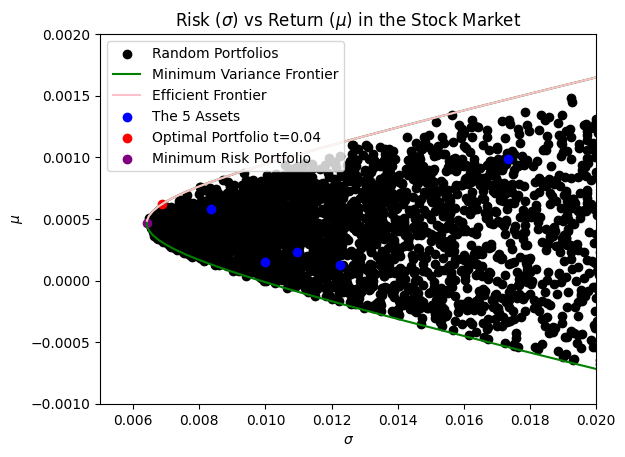

In [ ]:
plt.scatter(random_risk, random_return, color='black') # Question v

plt.plot(mv_frontier_s, mv_frontier_mu, color='green')
plt.plot(efficient_s, efficient_mu, color='pink') # Question iv


plt.scatter(risk_means, return_means, color='blue') # Question i

plt.scatter(investor_s, investor_mu, color='red') # Question ii

plt.scatter(min_risk_risk, min_risk_return, color='purple') # Question iii

plt.title('Risk ($\sigma$) vs Return ($\mu$) in the Stock Market')

plt.xlabel("$\sigma$")
plt.ylabel("$\mu$")

plt.legend(['Random Portfolios',
            'Minimum Variance Frontier',
            'Efficient Frontier',
            'The 5 Assets',
            'Optimal Portfolio t=0.04',
            'Minimum Risk Portfolio'])

plt.xlim(0.005, 0.02)
plt.ylim(-0.001, 0.002)

plt.show()

# Question 5

## a)

The optimal portfolio in a market with a risk-free asset may be found according to this formula.

$\hat{\vec x}(t) = (1 - t \vec eC^{-1}\overline r,
\space tC^{-1}\overline r)$

$C$ represents the covariance matrix of the market with only risky assets, and $\overline r$ reprents the mean returns of said market. The first element(s) of $\hat{\vec x}$ corresponds to the risk free asset(s), and the subsequent elements correspond to the risky assets.

In [ ]:
t = 0.04

rf_return = 0.0001 # return of risk-free asset
excess = return_means.copy()
for i, val in enumerate(excess):
  excess[i] -= rf_return

C_inv = np.linalg.inv(np.array(return_covs))
rf_investment = 0
for i, val in enumerate(C_inv):
  for j in val:
    rf_investment += j * excess[i]
rf_investment *= t
rf_investment = (1 - rf_investment)

new_portfolio = [rf_investment]

for i, val1 in enumerate(excess):
  row = 0
  for j, val2 in enumerate(C_inv):
    row += C_inv[j][i] * val1
  row *= t
  new_portfolio.append((row))

In [ ]:
# calculate mean return and risk
new_return = 0
new_return += new_portfolio[0] * rf_return
for i, val in enumerate(new_portfolio):
  if i:
    new_return += val * return_means[i - 1]
    print(val)
new_return = (new_return)

new_risk = 0
for i, val1 in enumerate(return_covs):
  for j, val2 in enumerate(val1):
    new_risk += (new_portfolio[i + 1]) * (new_portfolio[j + 1]) * val2
new_risk = (np.sqrt(new_risk))

0.118221450497659
0.021299184521410188
0.003434312114353041
0.006647855880437813
0.2066391739791015


The portfolio is displayed below.

In [ ]:
print("Portfolio for t = 0.04: ")

for i, val in enumerate(new_portfolio):
  if not i:
    print('  Risk-Free Asset:', '$' + str((round(val * 10000, 0))))
  elif val >= 0:
    print('  ' + stocks.columns[i] + ':', '$' + str((round(val * 10000, 0))))
  else:
    print('  ' + stocks.columns[i] + ':', '-$' + str(abs((round(val * 10000, 0)))))
print('\n')

print("Mean rerturn:",
      '$' + str(round(new_return * 10000, 2)))

print("Risk:",
      '$' + str(round(new_risk * 100, 3)))

Portfolio for t = 0.04: 
  Risk-Free Asset: $6438.0
  BHP: $1182.0
  CSL: $213.0
  NAB: $34.0
  TCL: $66.0
  TLS: $2066.0


Mean rerturn: $3.08
Risk: $0.267


## b)

### iv

In order to find the capital market line, it is necessary to find $\sigma_0$, which can be found according to the formula $\sqrt{\frac{a}{d} (r_0 - \frac{b}{a})^2 + \frac{1}{a}}$

In [ ]:
# find sigma_0
r_0 = rf_return

a = 0
for i in C_inv:
  for j in i:
    a += j
print(a)
b = 0
for i, val in enumerate(C_inv):
  for j in val:
    b += return_means[i] * j
print(b)
c = 0
for i, val1 in enumerate(C_inv):
  for j, val2 in enumerate(val1):
    c += return_means[i] * val2 * return_means[j]
print(c)
d = a * c - b ** 2
print(d)

sigma_0 = np.sqrt(a/d * (r_0 - b/a)**2 + 1/a)
print("sigma_0:", sigma_0)

24365.135964776287
11.342563021301666
0.009181727166820964
95.06029491887296
sigma_0: 0.008676845448872468


In [ ]:
cml_risk = np.linspace(0, 1, 100) # 'cml' denotes capital market line
cml_return = []
for i in cml_risk:
  cml_return.append(r_0 + sigma_0 * np.sqrt(d) * i)

### v

To find the expected return and risk of the market portfolio, it is necessary to compute the parameter $t_m$. It can be found from the formula $t_m = \frac{1}{b - ar_0}$

In [ ]:
# find market portfolio t parameter
t_m = 1 / (b - a * r_0)
t_m

0.11228323045374944

Find the market portfolio by finding the optimal portfolio for $t_m$.

In [ ]:
market_x = x(t_m)

print(market_x)
print(find_return(market_x))
print(find_risk(market_x))

[ 0.39696499  0.03639058 -0.11819688 -0.27997322  0.96481454]
0.0009035960256699109
0.009498966140691931


The market portfolio expected return can be found by this formula.

$\mu_M = \frac{c-br_0}{b-ar_0}$

$= \frac{c-br_0}{t_M}$

The market portfolio risk can be found by this formula.

$\sigma_m = \frac{\sigma_0\sqrt{d}}{b-ar_0}$

$=\frac{\sigma_0\sqrt{d}}{t_M}$

In [ ]:
mu_m = (c - b * r_0) * t_m
mu_m

0.0009035960256699111

In [ ]:
sigma_m = (sigma_0 * np.sqrt(d)) * t_m
sigma_m

0.009498966140691931

Here is the market portfolio, if $10,000 is invested.

In [ ]:
print("Portfolio for t = t_m: ")

print('  Risk-Free Asset:', '$' + str(abs(round(0 * 10000, 0))))
for i, val in enumerate(market_x):
  if val >= 0:
    print('  ' + stocks.columns[i] + ':', '$' + str((round(val * 10000, 0))))
  else:
    print('  ' + stocks.columns[i] + ':', '-$' + str(abs((round(val * 10000, 0)))))
print('\n')

print("Mean rerturn:",
      '$' + str(round(mu_m * 10000, 2)))

print("Risk:",
      '$' + str(round(sigma_m * 100, 3)))

Portfolio for t = t_m: 
  Risk-Free Asset: $0
  Date: $3970.0
  BHP: $364.0
  CSL: -$1182.0
  NAB: -$2800.0
  TCL: $9648.0


Mean rerturn: $9.04
Risk: $0.95


### Graph

The results are displayed graphically, as before.

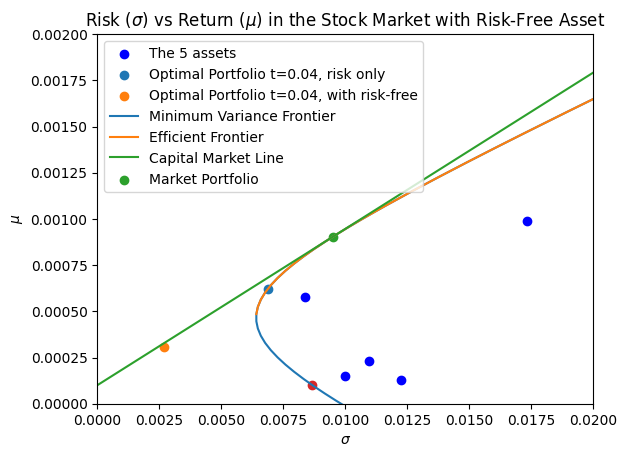

In [ ]:
plt.scatter(risk_means, return_means, color='blue') # Question i

plt.scatter(investor_s, investor_mu)
plt.scatter(new_risk, new_return) # Question ii

plt.plot(mv_frontier_s, mv_frontier_mu)
plt.plot(efficient_s, efficient_mu) # Question iii

plt.plot(cml_risk, cml_return) # Question iv

plt.scatter(sigma_m, mu_m) # Question v

plt.scatter(sigma_0, r_0)

plt.title("Risk ($\sigma$) vs Return ($\mu$) in the Stock Market with Risk-Free Asset")

plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

plt.legend(['The 5 assets',
            'Optimal Portfolio t=0.04, risk only',
            'Optimal Portfolio t=0.04, with risk-free',
            'Minimum Variance Frontier',
            'Efficient Frontier',
            'Capital Market Line',
            'Market Portfolio'])

plt.xlim(0, 0.02)
plt.ylim(0, 0.002)

plt.show()

# Question 6

## a)

The beta of a portfolio is defined as

$\beta = $Cov$(R_x, R_M)/\sigma^2_M$

The subscript $M$ denotes the market portfolio. The beta of a stock would be the beta of a portfolio consisting solely of that stock.


The value of Cov$(R_x,R_M)$ can be found using the expression $\vec x^T C \vec x_M$

In [ ]:
# find covariance with market portfolio return for each asset
cov_r_m = [] # the list of covariances between each asset and the market portfolio

for i, val1 in enumerate(return_covs):
  sum = 0
  for j, val2 in enumerate(val1):
    sum += val2 * market_x[j]
  cov_r_m.append(sum)

print(cov_r_m)

[9.993207510383699e-05, 1.45968199589874e-05, 3.368496913612467e-06, 5.6141615226874515e-06, 5.3895950617799726e-05]


The stock betas are displayed below.

In [ ]:
betas = cov_r_m.copy()

for i, val in enumerate(betas):
  betas[i] /= sigma_m ** 2

print("Betas for each stock:\n")

for i, val in enumerate(stocks.columns):
  if not i:
    continue
  print(val + ':', betas[i-1])

Betas for each stock:

BHP: 1.1075216546249826
CSL: 0.16177282595645787
NAB: 0.03733219060533632
TCL: 0.062220317675560605
TLS: 0.597315049685384


These betas are displayed, with the market portfolio beta displayed in purple, and the captial market line displayed in blue.

0.0009035960256699111
[0.00099, 0.00023, 0.00013, 0.00015, 0.00058]
0.000903596025669911


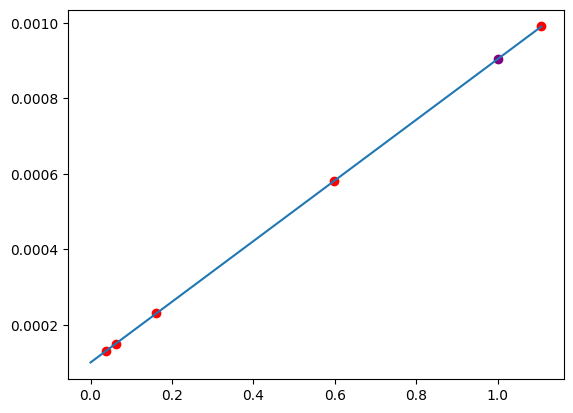

In [ ]:
sm_line = [] # security market line
sm_betas = np.linspace(0, betas[0], 100)
for i in sm_betas:
  sm_line.append(r_0 + i*(mu_m - r_0))

plt.scatter(betas, return_means, color='red')
plt.scatter(1, mu_m, color='purple')
plt.plot(sm_betas, sm_line)

print(mu_m)
print(return_means)
print(mu(t_m, return_means, return_covs))

## b)

The betas of BHP and TCL are very different. BHP has a large beta, greater than but almost equal to 1, indicating higher risk than the market, whereas TCL has a very low beta, indicating lower risk than the market. Firstly, according to the wikipedia pages, BHP has higher revenue, operating income, net income, total assets and total equity. This means that both the risk and return would be expected to be higher, since the underlying company is larger.